In [1]:
from astropy.table import Table
import matplotlib.pyplot as plt
import astropy
import desitarget.mock.build as mb
import numpy as np
from desitarget.targetmask import desi_mask, bgs_mask, mws_mask
import desitarget.mtl
%matplotlib inline

In [43]:
targetsfilename = "/Users/forero/data/DESI/decals/dr5/small_chunk_targets-dr5.0-0.16.2.fits"
targets = Table.read(targetsfilename)
nobj = len(targets)
truth = mb.empty_truth_table(nobj=nobj)
for k in targets.keys():
    if k in truth.keys():
        print(k)
        truth[k][:] = targets[k][:]

nothing = '          '
truth['TEMPLATESUBTYPE'] = np.repeat(nothing, nobj)
truth['TRUESPECTYPE'] = np.repeat(nothing, nobj)
truth['TEMPLATETYPE'] = np.repeat(nothing, nobj)

masks = ['BGS_ANY', 'ELG', 'LRG', 'QSO', 'STD_FSTAR', 'STD_BRIGHT']
dict_truspectype = {'BGS_ANY':'GALAXY', 'ELG':'GALAXY', 'LRG':'GALAXY', 'QSO':'QSO', 
                    'STD_FSTAR':'STAR', 'STD_BRIGHT':'STAR'}
dict_truetemplatetype = {'BGS_ANY':'BGS', 'ELG':'ELG', 'LRG':'LRG', 'QSO':'QSO', 
                        'STD_FSTAR':'STAR', 'STD_BRIGHT':'STAR'}
for m in masks:
    istype = (targets['DESI_TARGET'] & desi_mask.mask(m))!=0
    print(m, np.count_nonzero(istype))
    truth['TRUESPECTYPE'][istype] = np.repeat(dict_truspectype[m], np.count_nonzero(istype))
    truth['TEMPLATETYPE'][istype] = np.repeat(dict_truetemplatetype[m], np.count_nonzero(istype))
    truth['MOCKID'][istype] = targets['TARGETID'][istype]

n_unassigned = np.count_nonzero(truth['MOCKID']==0)
print('unassigned', n_unassigned)

mtl = desitarget.mtl.make_mtl(targets)
mtl.meta['EXTNAME'] = 'MTL'

isstd = (targets['DESI_TARGET'] & desi_mask.mask('STD_BRIGHT'))!=0
isstd |= (targets['DESI_TARGET'] & desi_mask.mask('STD_FSTAR'))!=0
print('standards', np.count_nonzero(isstd))
standards = mtl[isstd]


standards.write('standards.fits', overwrite=True)
mtl.write('mtl.fits', overwrite=True)
truth.write('truth.fits', overwrite=True)

FLUX_G
FLUX_R
FLUX_Z
FLUX_W1
FLUX_W2
TARGETID
BGS_ANY 182201
ELG 152960
LRG 32073
QSO 15384
STD_FSTAR 3219
STD_BRIGHT 608
unassigned 0
INFO:mtl.py:82:make_mtl: 3377 of 372791 targets have priority zero, setting N_obs=0.
standards 3394


In [44]:
set(truth['TRUESPECTYPE'])

{'GALAXY', 'QSO', 'STAR'}

In [86]:
import glob
from desisim.quickcat import quickcat
fiberassigndir = "/Users/forero/data/DESI/decals/dr5/fiberassign/"
tile_files = glob.glob(fiberassigndir+"tile_*.fits")
zcat = quickcat(tile_files, targets, truth, perfect=True)
zcat.write("zcat.fits", overwrite=True)

Thu Nov 16 22:26:00 2017 QC Reading 113 tiles
Thu Nov 16 22:26:02 2017 QC Trimming truth to just observed targets
Thu Nov 16 22:26:03 2017 QC Constructing new redshift catalog
Thu Nov 16 22:26:03 2017 QC Adding ZERR and ZWARN
Thu Nov 16 22:26:03 2017 QC Adding NUMOBS column
Thu Nov 16 22:26:06 2017 QC Merging previous zcat
Thu Nov 16 22:26:06 2017 QC done


In [87]:
from astropy.table import Table
import numpy as np
mtl = Table.read('mtl.fits')
zcat = Table.read("zcat.fits")
print("Efficiencies")
for objtype in ['BGS_ANY', 'ELG', 'LRG', 'QSO', 'STD_FSTAR', 'STD_BRIGHT']:
    ii = (mtl['DESI_TARGET'] & desi_mask.mask(objtype)) != 0
    jj = np.in1d(mtl['TARGETID'][ii], zcat['TARGETID'])
    n_in = np.count_nonzero(ii)
    n_out = np.count_nonzero(jj)
    print('{:10} {} {} {:.2f}'.format(objtype, n_in, n_out, n_out/n_in))

Efficiencies
BGS_ANY    182201 92158 0.51
ELG        152960 91367 0.60
LRG        32073 26433 0.82
QSO        15384 14790 0.96
STD_FSTAR  3219 2050 0.64
STD_BRIGHT 608 597 0.98


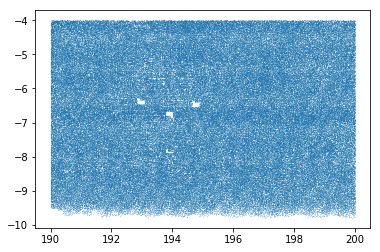

In [64]:
inzcat = np.in1d(mtl['TARGETID'], zcat['TARGETID'])
plt.scatter(mtl['RA'][inzcat], mtl['DEC'][inzcat], s=0.01)

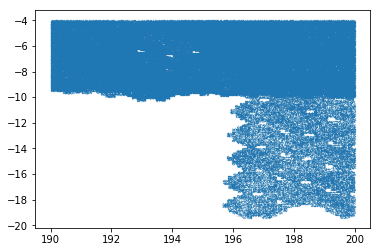

In [38]:
plt.scatter(mtl['RA'], mtl['DEC'], s=0.01)

In [65]:
print(zcat[0:10])
print(set(zcat['SPECTYPE']))

     TARGETID     BRICKNAME SPECTYPE  Z  ZERR ZWARN NUMOBS
----------------- --------- -------- --- ---- ----- ------
21991500732694575             GALAXY 0.0  0.0     0      1
21991500732694584             GALAXY 0.0  0.0     0      1
21991500732694607             GALAXY 0.0  0.0     0      2
21991500732694609             GALAXY 0.0  0.0     0      1
21991500732694642             GALAXY 0.0  0.0     0      1
21991500732694646             GALAXY 0.0  0.0     0      1
21991500732694660             GALAXY 0.0  0.0     0      1
21991500732694666             GALAXY 0.0  0.0     0      1
21991500732694672             GALAXY 0.0  0.0     0      1
21991500732694683             GALAXY 0.0  0.0     0      1
{'STAR', 'GALAXY', 'QSO'}


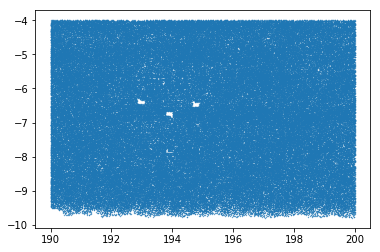

In [66]:
iselg = np.in1d(mtl['TARGETID'], zcat['TARGETID'][zcat['SPECTYPE']=='GALAXY'])
plt.scatter(mtl['RA'][iselg], mtl['DEC'][iselg], s=0.1)

BGS_ANY    182201 92158 0.51
ELG        152960 91367 0.60
LRG        32073 26433 0.82
QSO        15384 14790 0.96
STD_FSTAR  3219 2050 0.64
STD_BRIGHT 608 597 0.98
